In [1]:
import sys
assert sys.version_info >= (3,7)
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import glob
import warnings
warnings.filterwarnings("ignore")

if not cv.useOptimized():
    cv.setUseOptimized(True)

cv.useOptimized()

True

#### Note: Please use the default naming of files & folders provided

**1. Segmentation Annotation File**: "SignSeg90Annotation.txt" <br>
**2. Training Set Folder (4170 images)**: "tsrd_train" <br>
**3. Test Set Folder (1994 images)**: "tsrd_test" <br>
*Sample of 58 categories can be viewed in the "category_sample" folder.* <br>

To evaluate the performance of **segmentation model**, we use 90 images from the "tsrd_train" folder in which the image files are read using the Segmentation Annotation File as mentioned in item 1 above.

The **classification model** is tested with the test set folder as mentioned in item 3 above.

### Segmentation Model

In [2]:
def computeIOU(src1, src2):
    intersection = np.logical_and(src1, src2)
    union = np.logical_or(src1, src2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [3]:
# resize image to height 256 pixels with preserved ratio
def resize(image): 

    width = round(image.shape[1] / image.shape[0] * 256)
    resized = cv.resize(image, (width, 256), interpolation = cv.INTER_AREA)
    
    return resized


# contour detection
def contour(edge, resized):
    
    cnt = sorted(cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0], key = cv.contourArea)[-1]
    mask = np.zeros((resized.shape[0], resized.shape[1]), np.uint8)
    contoured = cv.drawContours(mask, [cnt], -1, 255, -1)
    dst = cv.bitwise_and(resized, resized, mask = mask)
    
    return contoured, dst, cnt


# edge detection
def canny(img):
    
    # finding the median of pixel intensity
    v = np.median(img)
    sigma = 0.05

    # calculate threshold based on median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))

    # edge detection
    edge = cv.Canny(img, lower, upper, 5, L2gradient = True)
    
    return edge

#### segmentation model WITHOUT resizing step

In [77]:
def segment1(file_path, display = True):
    acc = 0
    inacc = 0
    total_score = 0
    index = 0

    file = open(file_path, "r")
    write = open("inacc.txt", "w")
    
    for _ in file:
        index += 1
        annote = _.split(";")
        # load image files
        img = cv.imread("tsrd_train/" + annote[0])

        # preprocessing
        # resized = resize(img)
        copy = img.copy()

        img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

        shifted = cv.pyrMeanShiftFiltering(img, 5, 30)

        (H, S, V) = cv.split(img_hsv)

        # conversion to grayscale
        gray = cv.cvtColor(shifted, cv.COLOR_BGR2GRAY)

        # bilateral filter
        blur = cv.bilateralFilter(gray, 11, 47, 80)
        blurH = cv.bilateralFilter(H, 11, 47, 80)
        blurS = cv.bilateralFilter(S, 11, 47, 80)
        blurV = cv.bilateralFilter(V, 11, 47, 80)

        # adaptive thresholding
        thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 1)
        threshH = cv.adaptiveThreshold(blurH, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 1)
        threshS = cv.adaptiveThreshold(blurS, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 1)
        threshV = cv.adaptiveThreshold(blurV, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 1)

        # morphological operations
        kernel = np.ones((3, 3), np.uint8)
        imopen = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        imopenH = cv.morphologyEx(threshH, cv.MORPH_OPEN, kernel)    
        imopenS = cv.morphologyEx(threshS, cv.MORPH_OPEN, kernel)
        imopenV = cv.morphologyEx(threshV, cv.MORPH_OPEN, kernel)

        # canny detector
        edge = canny(imopen)
        edgeH = canny(imopenH)
        edgeS = canny(imopenS)
        edgeV = canny(imopenV)

        # applying contour
        contoured, dst, cnt = contour(edge, img)
        contouredh, dstH, cntH = contour(edgeH, img)
        contoureds, dstS, cntS = contour(edgeS, img)
        contouredv, dstV, cntV = contour(edgeV, img)

        # bounding box
        x, y, w, h = cv.boundingRect(cnt)
        x2, y2, w2, h2 = cv.boundingRect(cntS)
        x3, y3, w3, h3 = cv.boundingRect(cntV)

        a1 = w * h
        a2 = w2 * h2
        a3 = w3 * h3

        # finding largest area
        if (max(a1, a2, a3) == a1):
            res = dst
            cv.rectangle(copy, (x, y), (x + w, y + h), (0, 255, 0), 3)
            bb_res = [[x, y], [x + w, y], [x + w, y + h], [x, y + h]]
        elif (max(a1, a2, a3) == a2):
            res = dstS
            cv.rectangle(copy, (x2, y2), (x2 + w2, y2 + h2), (0, 255, 0), 3)
            bb_res = [[x2, y2], [x2 + w2, y2], [x2 + w2, y2 + h2], [x2, y2 + h2]]
        else:
            res = dstV
            cv.rectangle(copy, (x3, y3), (x3 + w3, y3 + h3), (0, 255, 0), 3)
            bb_res = [[x3, y3], [x3 + w3, y3], [x3 + w3, y3 + h3], [x3, y3 + h3]]

        # ground truth coordinate
        x_left = int(annote[3])
        y_left = int(annote[4])
        x_right = int(annote[5])
        y_right = int(annote[6])

        # ground truth
        bb_grd = [[x_left, y_left], [x_right, y_left], [x_right, y_right],[x_left, y_right]]
        grd_mask = np.zeros(img.shape).astype(img.dtype)
        grd_cnt = [np.array(bb_grd)]
        color = [255, 255, 255]
        cv.fillPoly(grd_mask, grd_cnt, color)
        ground_truth = cv.bitwise_and(img, grd_mask)

        # segmented region
        res_mask = np.zeros(img.shape).astype(img.dtype)
        res_cnt = [np.array(bb_res)]
        cv.fillPoly(res_mask, res_cnt, color)
        res_pts = cv.bitwise_and(img, res_mask)

        # IoU Score
        score = computeIOU(ground_truth, res_pts)
        total_score += score
        print('IoU {} : {:.2f}'.format(index, score))
        if (score < 0.80):
            write.write(annote[0] + '\n')
            inacc += 1
        else:
            acc += 1

        if (display):
            cv.imshow('Segmentation Result', np.hstack((res, copy)))        
            cv.waitKey(0)

    cv.destroyAllWindows()
    file.close()
    write.close()
    print('Total Accurate Segmentation:', acc)
    print('Total Inaccurate Segmentation:', inacc)
    print('Average IoU {:.2f}:'.format(total_score / 90))

#### 90 images from "tsrd_train" folder to test the segmentation model

In [78]:
segment1("SignSeg90Annotation.txt")

IoU 1 : 0.85
IoU 2 : 0.91
IoU 3 : 0.84
IoU 4 : 0.95
IoU 5 : 0.91
IoU 6 : 0.66
IoU 7 : 0.66
IoU 8 : 0.96
IoU 9 : 0.92
IoU 10 : 0.88
IoU 11 : 0.90
IoU 12 : 0.94
IoU 13 : 0.90
IoU 14 : 0.95
IoU 15 : 0.96
IoU 16 : 0.98
IoU 17 : 0.63
IoU 18 : 0.89
IoU 19 : 0.95
IoU 20 : 0.96
IoU 21 : 0.95
IoU 22 : 0.97
IoU 23 : 0.97
IoU 24 : 0.97
IoU 25 : 0.99
IoU 26 : 0.98
IoU 27 : 0.97
IoU 28 : 0.98
IoU 29 : 0.96
IoU 30 : 0.93
IoU 31 : 0.96
IoU 32 : 0.73
IoU 33 : 0.97
IoU 34 : 0.96
IoU 35 : 0.95
IoU 36 : 0.96
IoU 37 : 0.64
IoU 38 : 0.98
IoU 39 : 0.96
IoU 40 : 0.98
IoU 41 : 0.96
IoU 42 : 0.97
IoU 43 : 0.95
IoU 44 : 0.93
IoU 45 : 0.92
IoU 46 : 0.83
IoU 47 : 0.39
IoU 48 : 0.92
IoU 49 : 0.86
IoU 50 : 0.54
IoU 51 : 0.98
IoU 52 : 0.98
IoU 53 : 0.95
IoU 54 : 0.95
IoU 55 : 0.93
IoU 56 : 0.98
IoU 57 : 0.97
IoU 58 : 0.97
IoU 59 : 0.83
IoU 60 : 0.95
IoU 61 : 0.94
IoU 62 : 0.98
IoU 63 : 0.98
IoU 64 : 0.95
IoU 65 : 0.50
IoU 66 : 0.90
IoU 67 : 0.96
IoU 68 : 0.97
IoU 69 : 0.95
IoU 70 : 0.95
IoU 71 : 0.87
IoU 72 : 0.97
I

#### Resizing the image before segmentation

In [6]:
def segment2(file_path, display = True):

    file = open(file_path, "r")
    
    for _ in file:
        annote = _.split(";")
        # load image files
        img = cv.imread("tsrd_train/" + annote[0])

        # preprocessing
        resized = resize(img)
        copy = resized.copy()

        img_hsv = cv.cvtColor(resized, cv.COLOR_BGR2HSV)

        shifted = cv.pyrMeanShiftFiltering(resized, 5, 30)

        (H, S, V) = cv.split(img_hsv)

        # conversion to grayscale
        gray = cv.cvtColor(shifted, cv.COLOR_BGR2GRAY)

        # bilateral filter
        blur = cv.bilateralFilter(gray, 11, 47, 80)
        blurH = cv.bilateralFilter(H, 11, 47, 80)
        blurS = cv.bilateralFilter(S, 11, 47, 80)
        blurV = cv.bilateralFilter(V, 11, 47, 80)

        # adaptive thresholding
        thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 1)
        threshH = cv.adaptiveThreshold(blurH, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 1)
        threshS = cv.adaptiveThreshold(blurS, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 1)
        threshV = cv.adaptiveThreshold(blurV, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 1)

        # morphological operations
        kernel = np.ones((3, 3), np.uint8)
        imopen = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        imopenH = cv.morphologyEx(threshH, cv.MORPH_OPEN, kernel)    
        imopenS = cv.morphologyEx(threshS, cv.MORPH_OPEN, kernel)
        imopenV = cv.morphologyEx(threshV, cv.MORPH_OPEN, kernel)

        # canny detector
        edge = canny(imopen)
        edgeH = canny(imopenH)
        edgeS = canny(imopenS)
        edgeV = canny(imopenV)

        # applying contour
        contoured, dst, cnt = contour(edge, resized)
        contouredh, dstH, cntH = contour(edgeH, resized)
        contoureds, dstS, cntS = contour(edgeS, resized)
        contouredv, dstV, cntV = contour(edgeV, resized)

        # bounding box
        x, y, w, h = cv.boundingRect(cnt)
        x2, y2, w2, h2 = cv.boundingRect(cntS)
        x3, y3, w3, h3 = cv.boundingRect(cntV)

        a1 = w * h
        a2 = w2 * h2
        a3 = w3 * h3

        # finding largest area
        if (max(a1, a2, a3) == a1):
            res = dst
            cv.rectangle(copy, (x, y), (x + w, y + h), (0, 255, 0), 3)
        elif (max(a1, a2, a3) == a2):
            res = dstS
            cv.rectangle(copy, (x2, y2), (x2 + w2, y2 + h2), (0, 255, 0), 3)
        else:
            res = dstV
            cv.rectangle(copy, (x3, y3), (x3 + w3, y3 + h3), (0, 255, 0), 3)

        if (display):
            cv.imshow('Segmentation Result', np.hstack((res, copy)))        
            cv.waitKey(0)

    cv.destroyAllWindows()
    file.close()

In [7]:
# with resizing steps
segment2("SignSeg90Annotation.txt")

### Visualize Dataset

In [8]:
# load data set
X_train = [] 
X_test = []
y_train = []
y_test = []
y_train_color = [] # 0 --> red, 1 --> yellow, 2 --> blue, 3 --> black
y_test_color = []

# training set
file = open("TsignRecgTrain4170Annotation.txt", "r")
for _ in file:
    annote = _.split(";")
    img = cv.imread("tsrd_train/" + annote[0])
    X_train.append(img)
    category = int(annote[7])
    y_train.append(category)
    if ((category >= 0 and category <=17) or category == 33):
        y_train_color.append(0) # red
    elif (category == 18 or category == 19):
        y_train_color.append(3) # black
    elif (category >= 20 and category <= 31):
        y_train_color.append(2) # blue
    elif (category >= 32 and category <= 51):
        y_train_color.append(1) # yellow
    else:
        y_train_color.append(0)
file.close()

# test set
file = open("TsignRecgTest1994Annotation.txt", "r")
for _ in file:
    annote = _.split(";")
    img = cv.imread("tsrd_test/" + annote[0])
    X_test.append(img)
    category = int(annote[7])
    y_test.append(category)
    if ((category >= 0 and category <=17) or category == 33):
        y_test_color.append(0)
    elif (category == 18 or category == 19):
        y_test_color.append(3)
    elif (category >= 20 and category <= 31):
        y_test_color.append(2)
    elif (category >= 32 and category <= 51):
        y_test_color.append(1)
    else:
        y_test_color.append(0)
file.close()

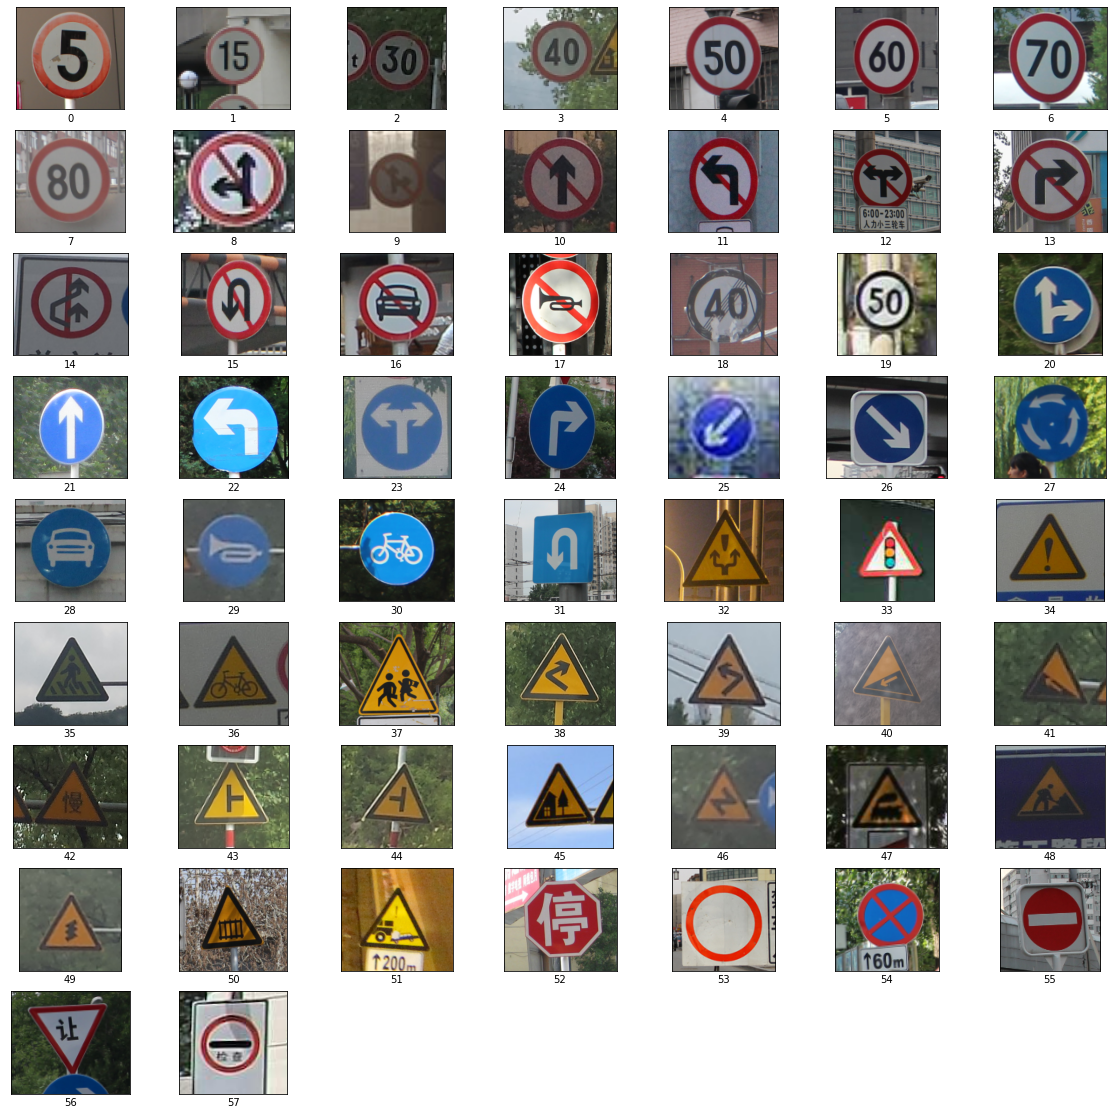

In [9]:
# 58 categories of the traffic sign
files = []
files.extend(glob.glob('category_sample/' + '*.png'))

plt.figure(figsize = (20, 20))

i = 0
for _ in files:
    sample = cv.imread(_)
    sample = cv.cvtColor(sample, cv.COLOR_BGR2RGB)
    plt.subplot(9, 7, i + 1)
    plt.imshow(sample)
    plt.xlabel(i)
    plt.xticks([]), plt.yticks([])
    plt.grid(False)
    i += 1
plt.show()

### Feature Extraction

#### HOG

In [10]:
def computeHOG(img):
    hog = cv.HOGDescriptor((64, 64), (64, 64), (8, 8), (8, 8), 16)
    descriptor = hog.compute(img).reshape(-1)

    return descriptor

In [11]:
def hog(img):
    # Calculate Gradients gx, gy
    gx = cv.Sobel(img, cv.CV_32F, 1, 0)
    gy = cv.Sobel(img, cv.CV_32F, 0, 1)
    
    # Calculate Gradient Magnitude and Direction
    magnitude, angle = cv.cartToPolar(gx, gy)
    
    # Number of bins
    bin_n = 16 
    bin = np.int32(bin_n * angle/(2 * np.pi))

    bin_cells = []
    mag_cells = []

    cellx = celly = 8

    for i in range(0, int(img.shape[0]/celly)):
        for j in range(0, int(img.shape[1]/cellx)):
            bin_cells.append(bin[i*celly : i*celly+celly, j*cellx : j*cellx+cellx])
            mag_cells.append(magnitude[i*celly : i*celly+celly, j*cellx : j*cellx+cellx])

    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hists = np.array(hists)
    print(hists.shape)
    hist = np.hstack(hists)

    # transform to Hellinger kernel
    eps = 1e-7
    hist /= hist.sum() + eps
    hist = np.sqrt(hist)
    hist /= np.linalg.norm(hist) + eps

    return hist

In [12]:
X_train_hog = []

for _ in range(len(X_train)):
    img = X_train[_]
    resized = cv.resize(img, (64, 64))
    hog_descriptor = hog(resized)
    X_train_hog.append(computeHOG(resized))

(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(

(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(

(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(

(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(

(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(

#### HSV Color Histogram & Color Moments

In [13]:
from scipy.stats import skew, kurtosis

In [14]:
def color_histogram(image):
    row, column, channel = image.shape[:3]
    hsv_range = [[0, 180], [0, 256], [0, 256]]

    feature = []
    for k in range(channel):
        # histSize = 16 bins
        histogram = np.squeeze(cv.calcHist([image], [k], None, [16], hsv_range[k]))
        histogram = histogram / (row * column)
        feature.extend(histogram)
        
    return feature

In [15]:
# moments per channel
def moment(channel):
    feature = []    
    feature.append(np.mean(channel))
    feature.append(np.std(channel))
    feature.append(skew(channel))
    feature.append(kurtosis(channel))
    return feature

In [16]:
def color_moment(image):
    row, column, channel = image.shape[:3]
    
    channel_list = []
    for i in range(channel):
        channel_list.append([])
    
    for i in range(row):
        for j in range(column):
            for k in range(channel):
                channel_list[k].append(image[i][j][k])
    
    feature = []
    for i in range(channel):
        feature.extend(moment(channel_list[i]))
    
    return feature

In [17]:
X_train_color = []
for _ in range(len(X_train)):
    img = cv.cvtColor(X_train[_], cv.COLOR_BGR2HSV)
    hist_features = color_histogram(img)
    moment_features = color_moment(img)
    X_train_color.append(hist_features + moment_features)
print('done')

done


#### BRISK

In [16]:
def detectFeatures(img):
    brisk = cv.BRISK_create()
    resized = resize(img)
    gray = cv.cvtColor(resized, cv.COLOR_BGR2GRAY)
    equ = cv.equalizeHist(gray)
    kp, des = brisk.detectAndCompute(equ, None)
    return des  

In [17]:
def bag_of_features(features, centres, k = 580):
    vec = np.zeros((1, k))
    for i in range(features.shape[0]):
        feat = features[i]
        diff = np.tile(feat, (k, 1)) - centres
        dist = pow(((pow(diff, 2)).sum(axis = 1)), 0.5)
        idx_dist = dist.argsort()
        idx = idx_dist[0]
        vec[0][idx] += 1
    return vec

In [18]:
def extractBRISK(data):
    
    features = []
    counter = 0
    for _ in range(len(data)):
        des = detectFeatures(data[_])
        if des is not None:
            features.append(des)
        else:
            counter += 1
            print(str(counter) + str(_) + ' -- no des')
    features = np.float32(np.vstack(features))
    
    # k-means cluster centres
    # samples, cluster(k) = 58 categories * 10, criteria = (type, max_iter = 10, epsilon = 0.1), attempts = 10, flag
    k = 580
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 0.1)
    flags = cv.KMEANS_RANDOM_CENTERS
    compactness, labels, centres = cv.kmeans(features, k, None, criteria, 10, flags)
    
    vector = []
    for _ in range(len(data)):
        des = detectFeatures(data[_])
        if des is not None:
            vec = bag_of_features(des, centres, k)
            vector.append(vec)
    
    return vector

In [19]:
X_train_brisk = []
X_train_brisk = extractBRISK(X_train)
print('done')

done


### Training

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

#### Training with HOG Features

In [24]:
category_HOG_clf = SVC(C = 10)
category_HOG_clf.fit(X_train_hog, y_train)

SVC(C=10)

In [42]:
y_pred = category_HOG_clf.predict(X_train_hog)

In [43]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        80
           3       1.00      1.00      1.00       260
           4       1.00      1.00      1.00        98
           5       1.00      1.00      1.00       194
           6       1.00      1.00      1.00        78
           7       1.00      1.00      1.00       152
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00        70
          11       1.00      1.00      1.00       138
          12       1.00      1.00      1.00        96
          13       1.00      1.00      1.00        36
          14       1.00      1.00      1.00       128
          15       1.00      1.00      1.00        22
          16       1.00      1.00      1.00       142
          17       1.00    

In [33]:
# processing for test set
X_test_hog = []
for _ in range(len(X_test)):
    img = X_test[_]
    resized = cv.resize(img, (64, 64))
    hog_descriptor = hog(resized)
    X_test_hog.append(computeHOG(resized))

(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(

(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(

(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 16)
(

In [44]:
y_pred = category_HOG_clf.predict(X_test_hog)

In [26]:
cfm = confusion_matrix(y_test, y_pred)

In [27]:
print(cfm)

[[14  0  0 ...  0  0  0]
 [ 4  8  0 ...  0  0  0]
 [ 0  0 44 ...  0  0  0]
 ...
 [ 0  0  0 ... 50  0  0]
 [ 0  0  0 ...  0 40  0]
 [ 0  0  0 ...  0  0  4]]


In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.35      1.00      0.52        14
           1       0.67      0.67      0.67        12
           2       0.47      0.70      0.56        60
           3       0.89      0.98      0.93        84
           4       0.60      0.86      0.70        58
           5       0.64      0.56      0.60        50
           6       1.00      0.80      0.89        30
           7       0.58      0.60      0.59        50
           8       1.00      1.00      1.00        14
          10       0.88      0.97      0.92        60
          11       1.00      0.86      0.93       130
          12       0.79      1.00      0.88        22
          13       1.00      0.83      0.90        92
          14       0.83      0.83      0.83        12
          15       1.00      0.33      0.50        36
          16       0.75      0.95      0.84        76
          17       1.00      0.88      0.94        84
          19       0.00    

#### Training for color classification using Color Features
    Code    Color
    --------------
     0      red
     1      yellow
     2      blue
     3      black

In [38]:
color_clf = SVC(C = 10)
color_clf.fit(X_train_color, y_train_color)

SVC(C=10)

In [39]:
y_pred = color_clf.predict(X_train_color)

In [40]:
print(classification_report(y_train_color, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2436
           1       0.86      0.78      0.82       722
           2       0.94      0.90      0.92      1000
           3       0.00      0.00      0.00        12

    accuracy                           0.92      4170
   macro avg       0.68      0.66      0.67      4170
weighted avg       0.91      0.92      0.91      4170



In [42]:
# processing for test set
X_test_color = []
for _ in range(len(X_test)):
    img = cv.cvtColor(X_test[_], cv.COLOR_BGR2HSV)
    hist_features = color_histogram(img)
    moment_features = color_moment(img)
    X_test_color.append(hist_features + moment_features)
print('done')

done


In [31]:
len(np.array(X_test_color)[0])

60

In [43]:
y_pred = color_clf.predict(X_test_color)

In [79]:
print(classification_report(y_test_color, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1194
           1       0.77      0.64      0.70       436
           2       0.78      0.74      0.76       364

    accuracy                           0.83      1994
   macro avg       0.80      0.77      0.79      1994
weighted avg       0.83      0.83      0.83      1994



#### Training with BRISK Features

In [45]:
# the features are in 3-dimensional array
np.array(X_train_brisk).shape

(4170, 1, 580)

In [46]:
# visualizing the brisk features array
np.array(X_train_brisk)

array([[[0., 1., 0., ..., 3., 0., 0.]],

       [[0., 0., 1., ..., 1., 0., 2.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[3., 2., 1., ..., 1., 1., 1.]],

       [[0., 1., 1., ..., 0., 2., 2.]],

       [[4., 0., 1., ..., 3., 0., 2.]]])

In [47]:
# reshape into 2d array
X_train_brisk_2d = np.array(X_train_brisk).reshape(4170, 580)

In [48]:
# visualizing the 2d array
X_train_brisk_2d

array([[0., 1., 0., ..., 3., 0., 0.],
       [0., 0., 1., ..., 1., 0., 2.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [3., 2., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 0., 2., 2.],
       [4., 0., 1., ..., 3., 0., 2.]])

In [67]:
category_BRISK_clf = SVC(C = 10)
category_BRISK_clf.fit(X_train_brisk_2d, y_train)

SVC(C=10)

In [50]:
y_pred = category_BRISK_clf.predict(X_train_brisk_2d)

In [51]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        80
           3       1.00      1.00      1.00       260
           4       1.00      1.00      1.00        98
           5       1.00      1.00      1.00       194
           6       1.00      1.00      1.00        78
           7       1.00      1.00      1.00       152
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00        70
          11       1.00      1.00      1.00       138
          12       1.00      1.00      1.00        96
          13       1.00      1.00      1.00        36
          14       1.00      1.00      1.00       128
          15       1.00      1.00      1.00        22
          16       1.00      1.00      1.00       142
          17       1.00    

In [52]:
# processing for test set
X_test_brisk = []
X_test_brisk = extractBRISK(X_test)
print('done')

done


In [53]:
np.array(X_test_brisk).shape[2]

580

In [59]:
X_test_brisk_2d = np.array(X_test_brisk).reshape(1994, 580)

In [92]:
y_pred = category_BRISK_clf.predict(X_test_brisk_2d)

In [93]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.14      0.25        14
           1       1.00      0.33      0.50        12
           2       1.00      0.90      0.95        60
           3       0.92      0.81      0.86        84
           4       0.89      0.83      0.86        58
           5       1.00      0.96      0.98        50
           6       1.00      0.73      0.85        30
           7       0.95      0.76      0.84        50
           8       1.00      0.43      0.60        14
          10       1.00      0.93      0.97        60
          11       0.81      0.88      0.84       130
          12       1.00      0.82      0.90        22
          13       0.87      0.89      0.88        92
          14       1.00      0.67      0.80        12
          15       1.00      0.72      0.84        36
          16       0.97      0.84      0.90        76
          17       0.94      0.74      0.83        84
          20       0.00    

### Classification Demo

In [45]:
def predict_category(res, feature = 0):
    if (feature == 0):
        img = cv.resize(res, (64, 64))
        res_hog = computeHOG(img)
        pred = category_HOG_clf.predict(res_hog.reshape(1, -1))[0]
    else: # feature = 1 for BRISK classification
        keypoint = np.array(extractBRISK(res))
        pred = category_BRISK_clf.predict(keypoint.reshape(keypoint.shape[0], keypoint.shape[2]))
    return pred

In [46]:
# code =   0       1       2         3
color = ['red', 'yellow', 'blue', 'black']

In [70]:
def predict_color(res):
    hist_features = color_histogram(res)
    moment_features = color_moment(res)
    color_features = hist_features + moment_features
    color_features = np.array(color_features).reshape(1, len(color_features))
    pred = color_clf.predict(color_features)
    return pred[0]

In [71]:
def classify_category(file):
    file = open(file, 'r')
    for _ in file:
        annote = _.split(";")
        
        img = cv.imread('tsrd_test/' + annote[0])
        resized = resize(img)
        img_hsv = cv.cvtColor(resized, cv.COLOR_BGR2HSV)

        res_category = predict_category(img_hsv, feature = 0)

        cv.putText(resized, "Predict: " + str(res_category), (10, 35), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        cv.putText(resized, "Actual: " + annote[7], (10, 225), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        
        cv.imshow('Classification Result', resized)
        cv.waitKey(0)
    
    cv.destroyAllWindows()

In [60]:
classify_category("TsignRecgTest1994Annotation.txt")

In [75]:
def classify_color(file):
    index = 0
    file = open(file, 'r')
    for _ in file:
        annote = _.split(";")
        
        img = cv.imread('tsrd_test/' + annote[0])
        resized = resize(img)
        img_hsv = cv.cvtColor(resized, cv.COLOR_BGR2HSV)

        res_color = predict_color(img_hsv)

        cv.putText(resized, "Predict: " + color[res_color], (10, 35), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        cv.putText(resized, "Actual: " + color[y_test_color[index]], (10, 225), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        
        cv.imshow('Classification Result', resized)
        cv.waitKey(0)
        index += 1
        
    cv.destroyAllWindows()

In [ ]:
classify_color("TsignRecgTest1994Annotation.txt")